In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## To do list 
1. Add mlp
2. run with smaller h_dim and z_dim 
3. minority class only VAE
4. Meeting on monday

# To do list 2
1. drop smaller classes ecoli
2. reduce the number of samples in the mnist (1:10, 1:15, 1:20)
3. averaging all experiments over ten runs
4. introduce imbalance in optical digits (one minority class)
5. trying different encoding dim n/2, n/4, ... 

# To do list 3
1. resample after training vae and train a different classifier (x10 and report average)
2. train ecoli over ten test-train split and average the results (mean and std  also)
3. additional datasets for experimentation

In [2]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = [np.reshape(x, -1) for x in train_images]
test_images= [np.reshape(x, -1) for x in test_images]
train_images[0].shape

(784,)

In [4]:

def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    min_col =[]
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
                min_col.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l, min_col

In [5]:
grouped_labels, min_label = group_all_labels(train_labels, 250, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_labels[r])

gr_min_data = []
gr_min_labels = []

class 0 : number of samples : 250
class 1 : number of samples : 250
class 2 : number of samples : 5958
class 3 : number of samples : 6131
class 4 : number of samples : 5842
class 5 : number of samples : 5421
class 6 : number of samples : 5918
class 7 : number of samples : 6265
class 8 : number of samples : 5851
class 9 : number of samples : 5949


In [6]:
print('minority data only')
gr_min_data = []
gr_min_labels = []
for index, q in enumerate(min_label):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_min_data.append(train_images[r])
        gr_min_labels.append(train_labels[r])


minority data only
class 0 : number of samples : 250
class 1 : number of samples : 250


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


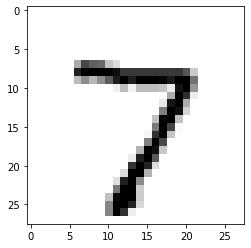

In [7]:
train_x = np.array(gr_data)
train_x = (train_x.astype(np.float32) / 255.0) 
test_x =  np.array(test_images)
test_images = (test_x.astype(np.float32)/255.0)

train_min_x = np.array(gr_min_data)
train_min_x = (train_min_x.astype(np.float32) / 255.0) 

train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_labels, num_classes=10, dtype='float32')
train_min_y = tf.keras.utils.to_categorical(gr_min_labels, num_classes=2, dtype='float32')

print(test_y[0])
plt.imshow(np.reshape(test_x[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

#  VAE Model

In [8]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
lr = 1e-3


def plot(samples, sz, shape):
    fig = plt.figure(figsize=(sz, sz))
    gs = gridspec.GridSpec(sz, sz)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(shape, shape), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

Instructions for updating:
non-resource variables are not supported in the long term


2021-10-11 07:19:21.727115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 07:19:21.842079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-11 07:19:21.854457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-11 07:19:21.856059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [9]:

# if not os.path.exists('vae_mnist_250/'):
#     os.makedirs('vae_mnist_250/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_x.shape[0], mb_size)
    X_mb = np.array(train_x[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {:0} Loss: {:0.4}'.format(it, loss))
        
#         samples=[]
#         for index in range(y_dim):
#             y = np.zeros([y_dim, y_dim])
#             y[range(y_dim), index] = 1
#             samples.extend(sess.run(X_samples,
#                            feed_dict={z: np.random.randn(y_dim, z_dim), c: y}))

#         fig = plot(samples, 10, 28)
#         plt.savefig('vae_mnist_250/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)

Iter: 0 Loss: 762.9
Iter: 1000 Loss: 146.3
Iter: 2000 Loss: 127.2
Iter: 3000 Loss: 119.6
Iter: 4000 Loss: 117.5
Iter: 5000 Loss: 113.7
Iter: 6000 Loss: 114.0
Iter: 7000 Loss: 119.5
Iter: 8000 Loss: 108.7
Iter: 9000 Loss: 115.5
Iter: 10000 Loss: 112.0
Iter: 11000 Loss: 108.8
Iter: 12000 Loss: 115.7
Iter: 13000 Loss: 110.1
Iter: 14000 Loss: 111.0
Iter: 15000 Loss: 107.4
Iter: 16000 Loss: 111.5
Iter: 17000 Loss: 112.8
Iter: 18000 Loss: 108.3
Iter: 19000 Loss: 105.8
Iter: 20000 Loss: 112.3
Iter: 21000 Loss: 102.8
Iter: 22000 Loss: 115.5
Iter: 23000 Loss: 109.2
Iter: 24000 Loss: 106.5
Iter: 25000 Loss: 109.4
Iter: 26000 Loss: 106.9
Iter: 27000 Loss: 109.5
Iter: 28000 Loss: 107.7
Iter: 29000 Loss: 107.0
Iter: 30000 Loss: 106.4
Iter: 31000 Loss: 111.7
Iter: 32000 Loss: 105.7
Iter: 33000 Loss: 106.7
Iter: 34000 Loss: 110.2
Iter: 35000 Loss: 104.7
Iter: 36000 Loss: 106.7
Iter: 37000 Loss: 108.1
Iter: 38000 Loss: 105.5
Iter: 39000 Loss: 105.6
Iter: 40000 Loss: 105.6
Iter: 41000 Loss: 106.9
Iter:

In [10]:
def generate_samples():
    samples = []
    gen_labels =[]
    for r in range(62):
        for index in range(2):
            gen_labels = gen_labels + [index]*mb_size
            y = np.zeros([mb_size, y_dim])
            y[range(mb_size), index] = 1
            samples.extend(sess.run(X_samples,
                                   feed_dict={z: np.random.randn(mb_size, z_dim), c: y}))

    gen_samples = np.array(samples)
    gen_labels = np.array(gen_labels)
    print(gen_samples.shape)
    print(gen_labels.shape)
    print(gen_labels[0])
    
    return gen_samples, gen_labels

# Visualize generated samples

(7936, 784)
(7936,)
0


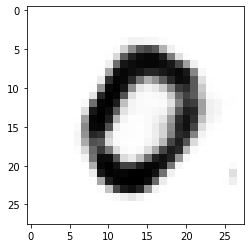

In [16]:
aug_data, aug_labels = generate_samples()
plt.imshow(np.reshape(aug_data[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

# MLP Model 

In [17]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential

def build_model(input_shape=(784,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

# Base line classification

In [18]:
bl_model = build_model()
batch_size=64
epochs=30
bl_history = bl_model.fit(train_x, train_y, batch_size=batch_size,
                    epochs=epochs, validation_data=(test_images, test_y))

bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
print('baseline test loss: ', bl_score[0])
print('baseline test accuracy: ', bl_score[1] )

from sklearn.metrics import classification_report
y_pred_oh = bl_model.predict(test_images)
y_pred_baseline = y_pred_oh.argmax(axis=-1)
print('MLP classification baseline\n', classification_report(test_labels, y_pred_baseline))


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 35us/sample - loss: 0.2890 - acc: 0.9147 - val_loss: 0.3026 - val_acc: 0.9043
Epoch 3/30
47835/47835 [==============================] - 2s 32us/sample - loss: 0.2317 - acc: 0.9331 - val_loss: 0.2817 - val_acc: 0.9135
Epoch 4/30
47835/47835 [==============================] - 1s 30us/sample - loss: 0.1953 - acc: 0.9426 - val_loss: 0.2346 - val_acc: 0.9273
Epoch 5/30
47835/47835 [==============================] - 1s 30us/sample - loss: 0.1760 - acc: 0.9477 - val_loss: 0.2103 - val_acc: 0.9364
Epoch 6/30
47835/47835 [==============================] - 1s 29us/sample - loss: 0.1600 - acc: 0.9523 - val_loss: 0.1734 - val_acc: 0.9471
Epoch 7/30
47835/47835 [==============================] - 1s 29us/sample - loss: 0.1444 - acc: 0.9565 - val_loss: 0.1817 - val_acc: 0.9455
Epoch 8/30
47835/47835 [==============================] - 1s 29us/sample - loss: 0.1428 - acc: 0.9575 - val_loss: 0.1588 - val_acc: 0.9515
Epoch 9/30
47835/47835 [==============

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


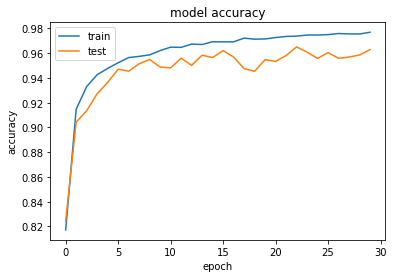

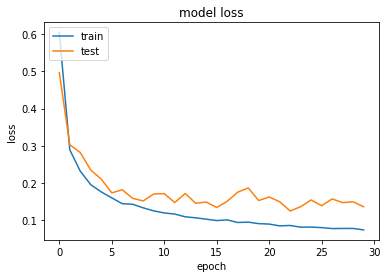

In [19]:
print(bl_history.history.keys())
plt.plot(bl_history.history['acc'])
plt.plot(bl_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(bl_history.history['loss'])
plt.plot(bl_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#  Augmentation experiment

In [20]:
results_list =[]
for i in range(10):
    gen_samples, gen_labels = generate_samples()
    X = np.concatenate([train_x, gen_samples])
    Y = np.concatenate([np.reshape(gr_labels, -1), gen_labels])

    Y_oh = np.array(tf.keras.utils.to_categorical(Y, num_classes=10, dtype='float32'))

    aug_model = build_model()
    aug_history = aug_model.fit(X, Y_oh, batch_size=batch_size,
                        epochs=epochs, validation_data=(test_images, test_y))

    aug_score = aug_model.evaluate(test_images, test_y, verbose=0)
    print('test loss for {}th run: '.format(i), aug_score[0])
    print('test accuracy for {}th run: '.format(i), aug_score[1] )
    
    y_pred_aug_oh = bl_model.predict(test_images)
    y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
    results_list.append(classification_report(test_labels, y_pred_aug, output_dict=True))

(7936, 784)
(7936,)
0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (No

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 34us/sample - loss: 0.2973 - acc: 0.9120 - val_loss: 0.1986 - val_acc: 0.9386
Epoch 3/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.2373 - acc: 0.9308 - val_loss: 0.1755 - val_acc: 0.9461
Epoch 4/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.2056 - acc: 0.9389 - val_loss: 0.1642 - val_acc: 0.9494
Epoch 5/30
55771/55771 [==============================] - 2s 33us/sample - loss: 0.1857 - acc: 0.9447 - val_loss: 0.1658 - val_acc: 0.9489
Epoch 6/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1712 - acc: 0.9493 - val_loss: 0.1479 - val_acc: 0.9572
Epoch 7/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1605 - acc: 0.9519 - val_loss: 0.1448 - val_acc: 0.9555
Epoch 8/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1479 - acc: 0.9562 - val_loss: 0.1671 - val_acc: 0.9517
Epoch 9/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 39us/sample - loss: 0.5956 - acc: 0.8172 - val_loss: 0.2677 - val_acc: 0.9161
Epoch 2/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.3043 - acc: 0.9112 - val_loss: 0.2512 - val_acc: 0.9239
Epoch 3/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.2510 - acc: 0.9261 - val_loss: 0.1957 - val_acc: 0.9418
Epoch 4/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.2218 - acc: 0.9341 - val_loss: 0.1961 - val_acc: 0.9423
Epoch 5/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.2033 - acc: 0.9385 - val_loss: 0.1772 - val_acc: 0.9474
Epoch 6/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1810 - acc: 0.9460 - val_loss: 0.1773 - val_acc: 0.9470
Epoch 7/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1669 - acc: 0.9496 - val_loss: 0.1678 - val_acc: 0.9491
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 38us/sample - loss: 0.5956 - acc: 0.8213 - val_loss: 0.2683 - val_acc: 0.9162
Epoch 2/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.3016 - acc: 0.9126 - val_loss: 0.2184 - val_acc: 0.9327
Epoch 3/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.2432 - acc: 0.9296 - val_loss: 0.2164 - val_acc: 0.9336
Epoch 4/30
55771/55771 [==============================] - 2s 33us/sample - loss: 0.2169 - acc: 0.9375 - val_loss: 0.2053 - val_acc: 0.9388
Epoch 5/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1949 - acc: 0.9443 - val_loss: 0.1828 - val_acc: 0.9454
Epoch 6/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1801 - acc: 0.9470 - val_loss: 0.1916 - val_acc: 0.9400
Epoch 7/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1677 - acc: 0.9498 - val_loss: 0.1780 - val_acc: 0.9449
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 37us/sample - loss: 0.6058 - acc: 0.8155 - val_loss: 0.2601 - val_acc: 0.9183
Epoch 2/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.3040 - acc: 0.9101 - val_loss: 0.1999 - val_acc: 0.9362
Epoch 3/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.2495 - acc: 0.9260 - val_loss: 0.1893 - val_acc: 0.9415
Epoch 4/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.2168 - acc: 0.9356 - val_loss: 0.1885 - val_acc: 0.9408
Epoch 5/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1965 - acc: 0.9412 - val_loss: 0.1648 - val_acc: 0.9493
Epoch 6/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1771 - acc: 0.9476 - val_loss: 0.1783 - val_acc: 0.9455
Epoch 7/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1649 - acc: 0.9517 - val_loss: 0.1648 - val_acc: 0.9478
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 36us/sample - loss: 0.6074 - acc: 0.8156 - val_loss: 0.2480 - val_acc: 0.9255
Epoch 2/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.3080 - acc: 0.9088 - val_loss: 0.2211 - val_acc: 0.9327
Epoch 3/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.2514 - acc: 0.9273 - val_loss: 0.1861 - val_acc: 0.9436
Epoch 4/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.2209 - acc: 0.9356 - val_loss: 0.1804 - val_acc: 0.9444
Epoch 5/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1962 - acc: 0.9434 - val_loss: 0.1874 - val_acc: 0.9399
Epoch 6/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1864 - acc: 0.9440 - val_loss: 0.1700 - val_acc: 0.9471
Epoch 7/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1720 - acc: 0.9486 - val_loss: 0.1525 - val_acc: 0.9536
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 41us/sample - loss: 0.5981 - acc: 0.8213 - val_loss: 0.2475 - val_acc: 0.9241
Epoch 2/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.2899 - acc: 0.9143 - val_loss: 0.2048 - val_acc: 0.9349
Epoch 3/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.2308 - acc: 0.9326 - val_loss: 0.1712 - val_acc: 0.9462
Epoch 4/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.2023 - acc: 0.9405 - val_loss: 0.1657 - val_acc: 0.9475
Epoch 5/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.1817 - acc: 0.9461 - val_loss: 0.1636 - val_acc: 0.9494
Epoch 6/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.1689 - acc: 0.9498 - val_loss: 0.1898 - val_acc: 0.9400
Epoch 7/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.1540 - acc: 0.9558 - val_loss: 0.1497 - val_acc: 0.9552
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 42us/sample - loss: 0.5874 - acc: 0.8242 - val_loss: 0.2689 - val_acc: 0.9179
Epoch 2/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.2877 - acc: 0.9172 - val_loss: 0.2179 - val_acc: 0.9325
Epoch 3/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.2316 - acc: 0.9327 - val_loss: 0.2146 - val_acc: 0.9342
Epoch 4/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.2041 - acc: 0.9409 - val_loss: 0.1828 - val_acc: 0.9411
Epoch 5/30
55771/55771 [==============================] - 2s 36us/sample - loss: 0.1832 - acc: 0.9463 - val_loss: 0.1656 - val_acc: 0.9479
Epoch 6/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.1671 - acc: 0.9509 - val_loss: 0.1611 - val_acc: 0.9496
Epoch 7/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.1532 - acc: 0.9547 - val_loss: 0.1565 - val_acc: 0.9523
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 38us/sample - loss: 0.5986 - acc: 0.8197 - val_loss: 0.2440 - val_acc: 0.9262
Epoch 2/30
55771/55771 [==============================] - 2s 33us/sample - loss: 0.2952 - acc: 0.9129 - val_loss: 0.2198 - val_acc: 0.9337
Epoch 3/30
55771/55771 [==============================] - 2s 32us/sample - loss: 0.2405 - acc: 0.9301 - val_loss: 0.1935 - val_acc: 0.9399
Epoch 4/30
55771/55771 [==============================] - 2s 32us/sample - loss: 0.2104 - acc: 0.9378 - val_loss: 0.2137 - val_acc: 0.9329
Epoch 5/30
55771/55771 [==============================] - 2s 32us/sample - loss: 0.1870 - acc: 0.9447 - val_loss: 0.1775 - val_acc: 0.9485
Epoch 6/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.1711 - acc: 0.9495 - val_loss: 0.1702 - val_acc: 0.9491
Epoch 7/30
55771/55771 [==============================] - 2s 36us/sample - loss: 0.1624 - acc: 0.9510 - val_loss: 0.1661 - val_acc: 0.9483
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 2s 42us/sample - loss: 0.5813 - acc: 0.8222 - val_loss: 0.2543 - val_acc: 0.9202
Epoch 2/30
55771/55771 [==============================] - 2s 32us/sample - loss: 0.2959 - acc: 0.9122 - val_loss: 0.2132 - val_acc: 0.9310
Epoch 3/30
55771/55771 [==============================] - 2s 32us/sample - loss: 0.2398 - acc: 0.9288 - val_loss: 0.1823 - val_acc: 0.9454
Epoch 4/30
55771/55771 [==============================] - 2s 35us/sample - loss: 0.2123 - acc: 0.9367 - val_loss: 0.1746 - val_acc: 0.9464
Epoch 5/30
55771/55771 [==============================] - 2s 36us/sample - loss: 0.1866 - acc: 0.9445 - val_loss: 0.1611 - val_acc: 0.9507
Epoch 6/30
55771/55771 [==============================] - 2s 34us/sample - loss: 0.1728 - acc: 0.9486 - val_loss: 0.1615 - val_acc: 0.9504
Epoch 7/30
55771/55771 [==============================] - 2s 33us/sample - loss: 0.1639 - acc: 0.9514 - val_loss: 0.1561 - val_acc: 0.9501
Epoch 8/30
55771/55771 [==============

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55771/55771 [==============================] - 3s 45us/sample - loss: 0.6115 - acc: 0.8171 - val_loss: 0.2596 - val_acc: 0.9206
Epoch 2/30
55771/55771 [==============================] - 2s 41us/sample - loss: 0.2950 - acc: 0.9149 - val_loss: 0.2423 - val_acc: 0.9276
Epoch 3/30
55771/55771 [==============================] - 2s 40us/sample - loss: 0.2414 - acc: 0.9304 - val_loss: 0.2403 - val_acc: 0.9281
Epoch 4/30
55771/55771 [==============================] - 2s 39us/sample - loss: 0.2120 - acc: 0.9383 - val_loss: 0.1910 - val_acc: 0.9445
Epoch 5/30
55771/55771 [==============================] - 2s 38us/sample - loss: 0.1929 - acc: 0.9431 - val_loss: 0.1804 - val_acc: 0.9452
Epoch 6/30
55771/55771 [==============================] - 2s 38us/sample - loss: 0.1740 - acc: 0.9486 - val_loss: 0.1661 - val_acc: 0.9486
Epoch 7/30
55771/55771 [==============================] - 2s 37us/sample - loss: 0.1642 - acc: 0.9515 - val_loss: 0.1497 - val_acc: 0.9547
Epoch 8/30
55771/55771 [==============

In [26]:
import pandas as pd
from collections import Counter

In [33]:
total_df = pd.DataFrame(results_list[0]).transpose()
print(len(results_list))
for r_dict in results_list[1:]:
    temp = pd.DataFrame(r_dict).transpose()
    total_df = total_df.add(temp)
    
average_10x = total_df/10.0
average_10x

10


,precision,recall,f1-score,support
0,0.994457,0.915306,0.953241,980.0000
1,0.994429,0.943612,0.968354,1135.0000
2,0.943044,0.978682,0.960533,1032.0000
3,0.954457,0.975248,0.964740,1010.0000
4,0.965657,0.973523,0.969574,982.0000
5,0.962963,0.961883,0.962423,892.0000
6,0.938247,0.983299,0.960245,958.0000
7,0.970789,0.969844,0.970316,1028.0000
8,0.948171,0.957906,0.953013,974.0000
9,0.958904,0.971259,0.965042,1009.0000
